# Groupings 

This notebook designs the schema `shared_projects` that specifies how teams are grouped for projects.

In [1]:
import datajoint as dj

In [2]:
schema = dj.schema("shared_projects")

Connecting dimitri@db.ust-db.link:3306


In [3]:
@schema
class Student(dj.Manual):
    definition = """
    username : varchar(12)
    ---
    first_name : varchar(30)
    last_name : varchar(30)
    """

In [4]:
# Insert student names from students.csv
with open('students.csv') as f:
    for line in f:
        fields = line.split(',')
        Student.insert1(dict(
            last_name=fields[0].strip(),
            first_name=fields[1].strip(),
            username=fields[2].strip()), skip_duplicates=True)

In [5]:
Student()

username,first_name,last_name
abellc,Creed Wills,Abell
antonie,Elton Jose Carlos,Antonio
byrneg,Garrick T.,Byrne
fuquend,Daniela,Fuquene
gallegjj,Juan J,Gallegos
hajdekd,Dalibor,Hajdek
hidalgdd,Diana D.,Hidalgo
kopinss,Sebastian,Kopinsky
llewis1,Lareisha,Lewis
lrharris,Lacey R,Harris


In [5]:
@schema
class Project(dj.Lookup):
    definition = """
    project_number : int
    ---
    project_name : varchar(300)
    due_date : date
    """
    
    contents = [
        (4, "Hotel database design", "2021-10-05"),
        (6, "Join Queries", "2021-11-03"),
        (7, "Aggregation Queries", "2021-11-10"),
        (8, "Query Review", "2021-11-17"),
        (9, "Final Project", "2021-12-12")
    ]

In [6]:
@schema
class GroupAssignment(dj.Manual):
    definition = """
    -> Project
    -> Student
    ---
    group_id : int
    """

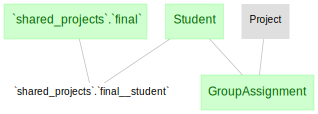

In [13]:
dj.Diagram(schema)

In [14]:
import itertools

# Assign Project 4 groupings
for k, r in zip(Student.fetch('KEY'), itertools.cycle(range(5))):
    GroupAssignment.insert1(dict(k, project_number=4, group_id=r), skip_duplicates=True)
    
# Assign Project 6 groupings
students = iter(Student.fetch('KEY'))
for group_id in range(5):
    for _ in range(3):
        GroupAssignment.insert1(dict(next(students), project_number=6, group_id=group_id), 
                                skip_duplicates=True)

In [15]:
dj.config['display.limit'] = 15

In [16]:
GroupAssignment * Project * Student & 'project_number=6' & 'group_id=4'

project_number,username,group_id,project_name,due_date,first_name,last_name
6,velasqya,4,Join Queries,2021-11-03,Yeison Andres,Velasquez
6,vnguyen8,4,Join Queries,2021-11-03,Viet,Nguyen
6,yzhang3,4,Join Queries,2021-11-03,Dora,Zhang


In [ ]:
for r in GroupAssignment * Project & {'project_number': 4}:
    print("GRANT SELECT, INSERT, UPDATE, DELETE, CREATE," 
          "DROP, REFERENCES, INDEX, ALTER, CREATE VIEW,"
          "SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE " 
          "ON `hw{project_number}_team{group_id}\_%`.* TO '{username}'@'%';".format(**r))

In [ ]:
GroupAssignment()

In [ ]:
GroupAssignment.fetch('KEY')

In [ ]:
# student triplets that have been in the same group

s1 = Student.proj(u1='username')
s2 = Student.proj(u2='username')
s3 = Student.proj(u3='username')


g1 = (GroupAssignment * dj.U('group_id')).proj(u1='username') 
g2 = (GroupAssignment * dj.U('group_id')).proj(u2='username')
g3 = (GroupAssignment * dj.U('group_id')).proj(u3='username')

order = 'u1 < u2 and u2 < u3'




In [ ]:
s1 * s2 * s3 & 'u1 < u2' & 'u2 < u3'

In [ ]:
dj.config['display.limit'] = 25

In [ ]:
g1 * g2 * g3 & order & '"hidalgdd" in (u1, u2, u3)'

In [ ]:
g1 * g2 * g3

In [ ]:
(GroupAssignment & 'project_number = 9').delete()

In [ ]:
Student()

In [17]:
@schema
class Final(dj.Manual):
    definition = """
    final : varchar(18)
    """
    
    class Student(dj.Part):
        definition = """
        -> master
        -> Student
        """

In [18]:
Final.insert(
    zip(("magnificents", "black_squares", 
         "not_remote", "future_soldiers")),
    skip_duplicates=True)

In [22]:
Final.Student.insert((
    ("black_squares", "mhines"),
    ("black_squares", "fuquend"),
    ("black_squares", "llewis1"),
    ("magnificents", "hajdekd"),
    ("magnificents", "byrneg"),
    ("magnificents", "hidalgdd"),
    ("magnificents", "lrharris"),
    ("not_remote", "gallegjj"),
    ("not_remote", "yzhang3"),
    ("not_remote", "shussai"),
    ("not_remote", "abellc"),
    ("future_soldiers", "antonie"),
    ("future_soldiers", "kopinss"),
    ("future_soldiers", "velasqya")
), skip_duplicates=True)

In [29]:
dj.config['display.limit'] = 15
Final.Student() * Student.proj(name='concat(first_name, " ", last_name)')

final,username,name calculated attribute
black_squares,fuquend,Daniela Fuquene
black_squares,llewis1,Lareisha Lewis
black_squares,mhines,Michael Hines
future_soldiers,antonie,Elton Jose Carlos Antonio
future_soldiers,kopinss,Sebastian Kopinsky
future_soldiers,velasqya,Yeison Andres Velasquez
magnificents,byrneg,Garrick T. Byrne
magnificents,hajdekd,Dalibor Hajdek
magnificents,hidalgdd,Diana D. Hidalgo
magnificents,lrharris,Lacey R Harris


In [24]:
unassigned = Student - Final.Student
unassigned

username,first_name,last_name
vnguyen8,Viet,Nguyen


In [30]:
for q in Final.Student():
     print("GRANT SELECT, INSERT, UPDATE, DELETE, CREATE,"
           " DROP, REFERENCES, INDEX, ALTER, CREATE VIEW," 
           " SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE"
           " ON `{final}\_%`.* TO '{username}'@'%';".format(**q))

GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE ON `black_squares\_%`.* TO 'fuquend'@'%';
GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE ON `black_squares\_%`.* TO 'llewis1'@'%';
GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE ON `black_squares\_%`.* TO 'mhines'@'%';
GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE ON `future_soldiers\_%`.* TO 'antonie'@'%';
GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE ON `future_soldiers\_%`.* TO 'kopinss'@'%';
GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, REFERENCES, INDEX, ALTER, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROU

In [ ]:
for name, password in creds:
    print(f"GRANT SELECT, INSERT, UPDATE, DELETE, "
          f"CREATE, DROP, REFERENCES, INDEX, ALTER, "
          f"CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE "
          f"ON `{name}\_%`.* TO '{name}'@'%';")

In [ ]:
# make new teams that have never been together

assigned = set()
project = 9
group = 0
for u1, u2, u3, n in zip(*teammates.fetch('u1', 'u2', 'u3', 'n', order_by='n')):
    if not assigned & {u1, u2, u3}:
        try:
            GroupAssignment.insert(
                dict(project_number=project, group_id=group, username=user)
                for user in (u1, u2, u3))
        except dj.errors.DuplicateError:
            pass
        else:
            group += 1
            assigned.update({u1, u2, u3})
            print(u1, u2, u3)
        
        
assert len(assigned)==len(Student()), 'some students have not been assigned'

In [ ]:
GroupAssignment & 'project_number=9'

In [ ]:
(GroupAssignment() & 'project_number=7').delete()

In [ ]:
GroupAssignment() & 'project_number=7'

In [ ]:
teammates & 'u1 < u2' & 'u2 < u3'

In [ ]:
GroupAssignment() & dj.top(3, order_by='')

In [ ]:
teammates & order

In [ ]:
teammates & order & 'u1="abellc"'

In [ ]:
GroupAssignment() & 'username="abellc"'

In [ ]:
Student()

In [ ]:
teammates & order

In [10]:
GroupAssignment() & 'project_number=8' & 'group_id=2'

project_number,username,group_id
8,abellc,2
8,velasqya,2
8,vnguyen8,2
